In [1]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions;

In [2]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end;

In [3]:
# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [4]:
# In the mass basis, which is what we want for propagation thru the vacuum
function DSNB_integrand(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    else
        return 0
    end
end

function DSNB_integrand_ccsn(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z), i, "large", ordering, nubar))
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z), i, "large", ordering, nubar))
    else
        return 0
    end
end

function DSNB_integrand_bhsn(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z), i, "bh", ordering, nubar)
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(125, 15)*Fmass(E*(1+z), i, "bh", ordering, nubar)
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(125, 40)*Fmass(E*(1+z), i, "bh", ordering, nubar)
    else
        return 0
    end
end


DSNBmass(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1]

DSNB_ccsn(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand_ccsn.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1]
DSNB_bhsn(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand_bhsn.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1];

In [5]:
es_dsnb = range(0, 40, 100)
dsnb_ccsn_1 = DSNB_ccsn.(es_dsnb, 1, "NO", false, "21")
dsnb_bhsn_1 = DSNB_bhsn.(es_dsnb, 1, "NO", false, "21")
dsnb_1 = DSNBmass.(es_dsnb, 1, "NO", false, "21");

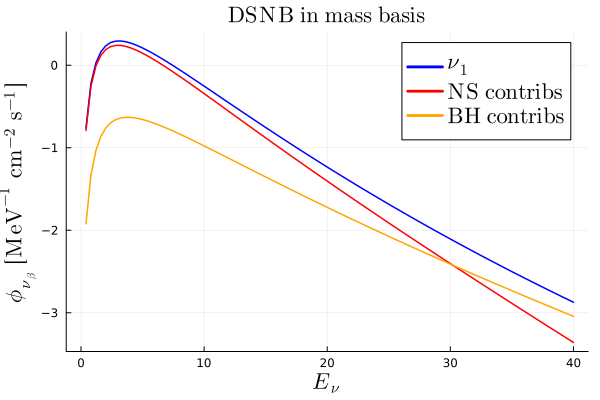

In [6]:
p1 = plot(es_dsnb, 
    [log10.(dsnb_1) log10.(dsnb_ccsn_1) log10.(dsnb_bhsn_1)],
    c=[:blue :red :orange],
    lw=1.5,
    ls=[:solid :solid :solid],
    label=[L"\nu_1" L"\mathrm{NS~contribs}" L"\mathrm{BH~contribs}"],
    title=L"\mathrm{DSNB~in~mass~basis}",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
)

In [7]:
# Trying to implement decays now

# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*leff(z)/E)
end;

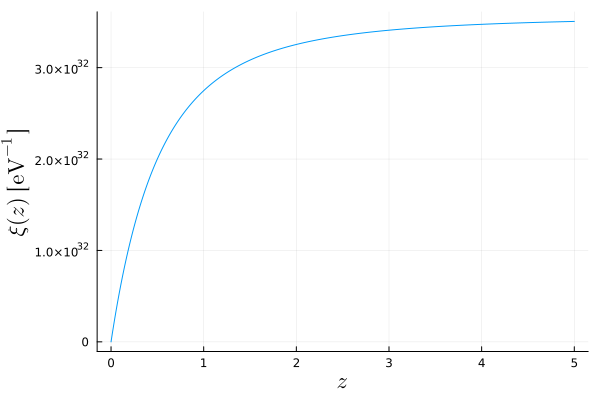

In [8]:
zs_plot = range(0, 5, 1000)
plot(
    zs_plot,
    4.68e34*leff.(zs_plot),
    label=false,
    xlabel=L"z",
    ylabel=L"\xi(z)~[\mathrm{eV^{-1}}]",
    xguidefontsize=15,
    yguidefontsize=15,
    legendfontsize=15
)

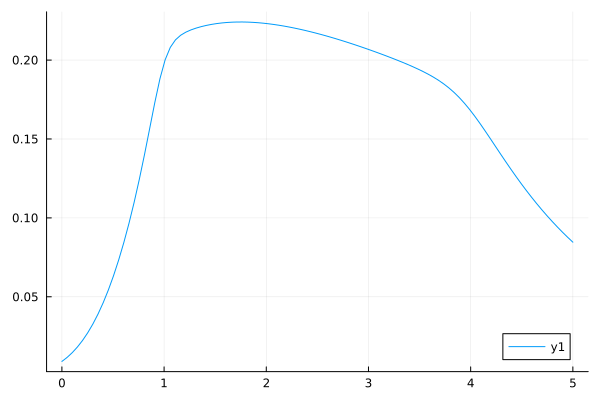

In [9]:
etest = 1
zs_test = range(0, 5, 100)
dsnb_integrand_test = 0.00208*DSNB_integrand.(etest, zs_test, 1, "NO", false, "21")
plot(zs_test, dsnb_integrand_test)

In [10]:
function decay_integrand(E, z, α, i, ordering, nubar, bh_frac)
    if α == 0
        return DSNB_integrand(E, z, i, ordering, nubar, bh_frac)
    else
        return DSNB_integrand(E, z, i, ordering, nubar, bh_frac)*decay(E, α, z)
    end
end

function DSNB_idecay(E, α, i, ordering, nubar, bh_frac)
    return 0.00208*quadgk(z -> decay_integrand(E, z, α, i, ordering, nubar, bh_frac), 0, 5)[1]
end

function DSNB_idecay_test(E, α, i, ordering, nubar, bh_frac)
    return quadgk(z -> (10^10)*DSNB_integrand(E, z, i, ordering, nubar, bh_frac)*decay(E, α, z), 0, 0.1)[1]
end;

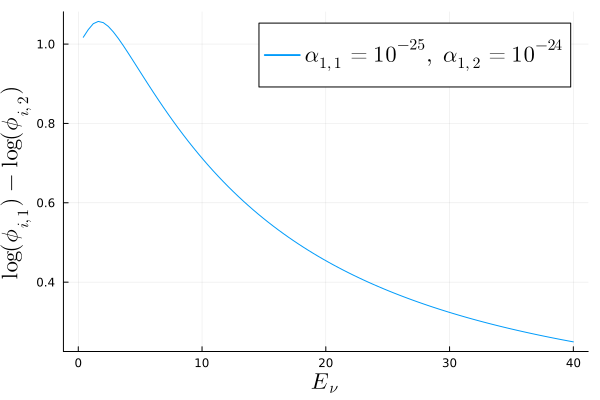

In [12]:
z_eval = 0.1
# dsnbintegrand_test_24 = DSNB_integrand.(es_dsnb, z_eval, 1, "NO", false, "21") .* decay.(es_dsnb, 10^(-24), z_eval)
# dsnbintegrand_test_25 = DSNB_integrand.(es_dsnb, z_eval, 1, "NO", false, "21") .* decay.(es_dsnb, 10^(-25), z_eval)

dsnbint_test_24 = DSNB_idecay_test.(es_dsnb, 10^(-24), 1, "NO", false, "21")
dsnbint_test_25 = DSNB_idecay_test.(es_dsnb, 10^(-25), 1, "NO", false, "21")

log10.(dsnbint_test_25) .- log10.(dsnbint_test_24)

plot(
    es_dsnb,
    log10.(dsnbint_test_25) .- log10.(dsnbint_test_24),
    ylabel=L"\log(\phi_{i,1}) - \log(\phi_{i, 2})",
    xlabel=L"E_\nu",
    label=L"\alpha_{1, 1} = 10^{-25},~\alpha_{1,2} = 10^{-24}",
    xguidefontsize=15,
    yguidefontsize=15,
    legendfontsize=15
)

In [13]:
function DSNB_idecay_fastint(E, α, i, ordering, nubar, bh_frac)
    zgrid = range(0, 5, 1000)
    dz = zgrid[2] - zgrid[1]
    return 0.00208*sum(decay_integrand.(E, zgrid, α, i, ordering, nubar, bh_frac) .* dz)
end

DSNB_idecay_fastint (generic function with 1 method)

In [14]:
function DSNB_idecay_flavor(E, β, α1, α2, α3, ordering, nubar, bh_frac)
    ν1 = DSNB_idecay(E, α1, 1, ordering, nubar, bh_frac)
    ν2 = DSNB_idecay(E, α2, 2, ordering, nubar, bh_frac)
    ν3 = DSNB_idecay(E, α3, 3, ordering, nubar, bh_frac)
    if β == "e"
        i = 1
    elseif β == "μ"
        i = 2
    elseif β == "τ"
        i = 3
    else
        return 0.0
    end
    return Usqred(ordering)[i, 1]*ν1 + Usqred(ordering)[i, 2]*ν2 + Usqred(ordering)[i, 3]*ν3
end

function DSNB_idecay_flavor_fastint(E, β, α1, α2, α3, ordering, nubar, bh_frac)
    ν1 = DSNB_idecay_fastint(E, α1, 1, ordering, nubar, bh_frac)
    ν2 = DSNB_idecay_fastint(E, α2, 2, ordering, nubar, bh_frac)
    ν3 = DSNB_idecay_fastint(E, α3, 3, ordering, nubar, bh_frac)
    if β == "e"
        i = 1
    elseif β == "μ"
        i = 2
    elseif β == "τ"
        i = 3
    else
        return 0.0
    end
    return Usqred(ordering)[i, 1]*ν1 + Usqred(ordering)[i, 2]*ν2 + Usqred(ordering)[i, 3]*ν3
end

DSNB_idecay_flavor_fastint (generic function with 1 method)

In [35]:
DSNB_sim = readdlm("Data/Miller-DSNB-flux-corrected.txt", comments=true)
dsnb_sim_es, dsnb_sim_ν1, dsnb_sim_ν2, dsnb_sim_ν3 = [DSNB_sim[:, i] for i in 1:4];

In [36]:
function dsnb_sim(i, nubar, α)
    if α == 0
        if nubar == false
            if i == 1
                nuvec = DSNB_sim[:, 2]
            elseif i == 2
                nuvec = DSNB_sim[:, 3]
            elseif i == 3
                nuvec = DSNB_sim[:, 4]
            else
                return 0
            end
        elseif nubar == true
            if i == 1
                nuvec = DSNB_sim[:, 5]
            elseif i == 2
                nuvec = DSNB_sim[:, 6]
            elseif i == 3
                nuvec = DSNB_sim[:, 7]
            else
                return 0
            end
        else
            return 0
        end
    elseif α == [1, 1e-25]
        if nubar == false
            if i == 1
                nuvec = DSNB_sim[:, 8]
            elseif i == 2
                nuvec = DSNB_sim[:, 9]
            elseif i == 3
                nuvec = DSNB_sim[:, 10]
            else
                return 0
            end
        elseif nubar == true
            if i == 1
                nuvec = DSNB_sim[:, 11]
            elseif i == 2
                nuvec = DSNB_sim[:, 12]
            elseif i == 3
                nuvec = DSNB_sim[:, 13]
            else
                return 0
            end
        else
            return 0
        end
    elseif α == [1, 1e-24]
        if nubar == false
            if i == 1
                nuvec = DSNB_sim[:, 14]
            elseif i == 2
                nuvec = DSNB_sim[:, 15]
            elseif i == 3
                nuvec = DSNB_sim[:, 16]
            else
                return 0
            end
        elseif nubar == true
            if i == 1
                nuvec = DSNB_sim[:, 17]
            elseif i == 2
                nuvec = DSNB_sim[:, 18]
            elseif i == 3
                nuvec = DSNB_sim[:, 19]
            else
                return 0
            end
        else
            return 0
        end
    elseif α == [2, 1e-25]
        if nubar == false
            if i == 1
                nuvec = DSNB_sim[:, 20]
            elseif i == 2
                nuvec = DSNB_sim[:, 21]
            elseif i == 3
                nuvec = DSNB_sim[:, 22]
            else
                return 0
            end
        elseif nubar == true
            if i == 1
                nuvec = DSNB_sim[:, 23]
            elseif i == 2
                nuvec = DSNB_sim[:, 24]
            elseif i == 3
                nuvec = DSNB_sim[:, 25]
            else
                return 0
            end
        else
            return 0
        end
    elseif α == [2, 1e-24]
        if nubar == false
            if i == 1
                nuvec = DSNB_sim[:, 26]
            elseif i == 2
                nuvec = DSNB_sim[:, 27]
            elseif i == 3
                nuvec = DSNB_sim[:, 28]
            else
                return 0
            end
        elseif nubar == true
            if i == 1
                nuvec = DSNB_sim[:, 29]
            elseif i == 2
                nuvec = DSNB_sim[:, 30]
            elseif i == 3
                nuvec = DSNB_sim[:, 31]
            else
                return 0
            end
        else
            return 0
        end
    else
        return 0
    end

    dsnb_ne = Interpolations.interpolate((vec(DSNB_sim[:, 1]),), nuvec, Gridded(Linear()))
    dsnb = extrapolate(dsnb_ne, 0.0)
    
end

dsnb_sim (generic function with 1 method)

In [37]:
dsnb_sim_1_nodecay = dsnb_sim(1, false, 0)
dsnb_sim_1_α1_25 = dsnb_sim(1, false, [1, 1e-25])
dsnb_sim_1_α1_24 = dsnb_sim(1, false, [1, 1e-24])
dsnb_sim_2_α2_25 = dsnb_sim(2, false, [2, 1e-25])
dsnb_sim_2_α2_24 = dsnb_sim(2, false, [2, 1e-24])

dsnb_sim_1bar_nodecay = dsnb_sim(1, true, 0)
dsnb_sim_1bar_α1_25 = dsnb_sim(1, true, [1, 1e-25])
dsnb_sim_1bar_α1_24 = dsnb_sim(1, true, [1, 1e-24])
dsnb_sim_2bar_α2_25 = dsnb_sim(2, true, [2, 1e-25])
dsnb_sim_2bar_α2_24 = dsnb_sim(2, true, [2, 1e-24])
;

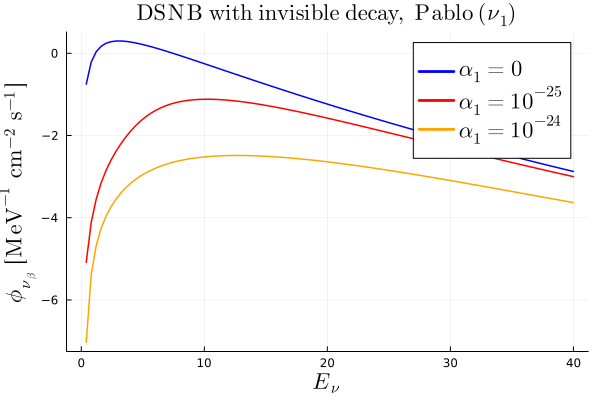

In [38]:
p1 = plot(es_dsnb, 
    [log10.(dsnb_sim_1_nodecay.(es_dsnb)) log10.(dsnb_sim_1_α1_25.(es_dsnb)) log10.(dsnb_sim_1_α1_24.(es_dsnb))],
    c=[:blue :red :orange :yellow],
    lw=1.5,
    ls=[:solid :solid :solid :solid],
    label=[L"\alpha_1 = 0" L"\alpha_1 = 10^{-25}" L"\alpha_1 = 10^{-24}"],
    title=L"\mathrm{DSNB~with~invisible~decay,~Pablo}~(\nu_1)",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
)

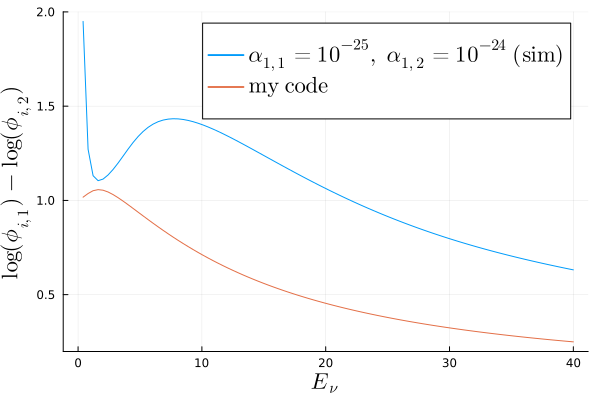

In [39]:
plot(
    es_dsnb,
    [log10.(dsnb_sim_1_α1_25.(es_dsnb)) .- log10.(dsnb_sim_1_α1_24.(es_dsnb)) log10.(dsnbint_test_25) .- log10.(dsnbint_test_24)],
    ylabel=L"\log(\phi_{i,1}) - \log(\phi_{i, 2})",
    xlabel=L"E_\nu",
    label=[L"\alpha_{1, 1} = 10^{-25},~\alpha_{1,2} = 10^{-24}~(\mathrm{sim})" L"\mathrm{my~code}"],
    xguidefontsize=15,
    yguidefontsize=15,
    legendfontsize=15
)

In [22]:
dsnb_nodecay_test_1 = DSNB_idecay_fastint.(es_dsnb, 0, 1, "NO", false, "21");

In [23]:
dsnb_idecay_test_1_1e23 = DSNB_idecay.(es_dsnb, 10^(-23), 1, "NO", false, "21")
dsnb_idecay_test_1_1e24 = DSNB_idecay.(es_dsnb, 10^(-24), 1, "NO", false, "21")
dsnb_idecay_test_1_1e25 = DSNB_idecay.(es_dsnb, 10^(-25), 1, "NO", false, "21")
dsnb_idecay_test_1_1e26 = DSNB_idecay.(es_dsnb, 10^(-26), 1, "NO", false, "21");

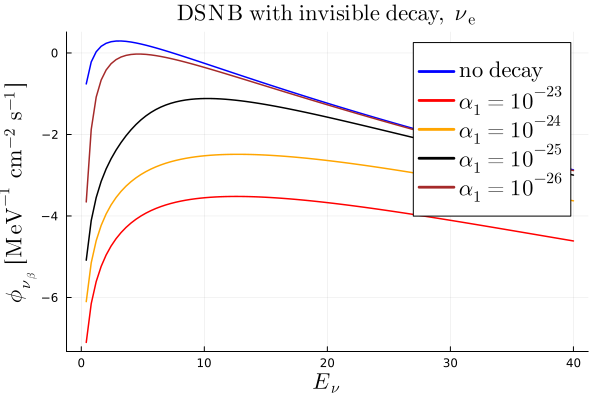

In [25]:
p1 = plot(es_dsnb, 
    [log10.(dsnb_nodecay_test_1) log10.(dsnb_idecay_test_1_1e23) log10.(dsnb_idecay_test_1_1e24) log10.(dsnb_idecay_test_1_1e25) log10.(dsnb_idecay_test_1_1e26)],
    c=[:blue :red :orange :black :brown :pink],
    lw=1.5,
    ls=:solid,
    label=[L"\mathrm{no~decay}" L"\alpha_1 = 10^{-23}" L"\alpha_1 = 10^{-24}" L"\alpha_1 = 10^{-25}" L"\alpha_1 = 10^{-26}"],
    title=L"\mathrm{DSNB~with~invisible~decay,~\nu_e}",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
)

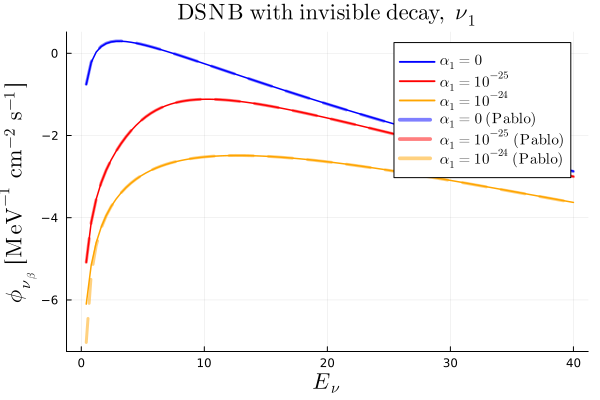

In [43]:
plot(es_dsnb, 
    [log10.(dsnb_nodecay_test_1) log10.(dsnb_idecay_test_1_1e25) log10.(dsnb_idecay_test_1_1e24)],
    c=[:blue :red :orange :black :brown :pink],
    lw=1.5,
    ls=:solid,
    label=[L"\alpha_1 = 0" L"\alpha_1 = 10^{-25}" L"\alpha_1 = 10^{-24}"],
    title=L"\mathrm{DSNB~with~invisible~decay,~\nu_1}",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=10,
)

plot!(es_dsnb, 
    [log10.(dsnb_sim_1_nodecay.(es_dsnb)) log10.(dsnb_sim_1_α1_25.(es_dsnb)) log10.(dsnb_sim_1_α1_24.(es_dsnb))],
    c=[:blue :red :orange :yellow],
    lw=3,
    alpha=0.5,
    ls=:dash,
    label=[L"\alpha_1 = 0~(\mathrm{Pablo})" L"\alpha_1 = 10^{-25}~(\mathrm{Pablo})" L"\alpha_1 = 10^{-24}~(\mathrm{Pablo})"],
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=10,
)

In [26]:
dsnb_nodecay_test_νe = DSNB_idecay_flavor.(es_dsnb, "e", 0, 0, 0, "NO", false, "21");

In [27]:
dsnb_idecay_test_νe_24 = DSNB_idecay_flavor.(es_dsnb, "e", 10^(-24), 0, 0, "NO", false, "21")
dsnb_idecay_test_νe_25 = DSNB_idecay_flavor.(es_dsnb, "e", 10^(-25), 0, 0, "NO", false, "21");

In [28]:
dsnb_idecay_test_νe_26 = DSNB_idecay_flavor.(es_dsnb, "e", 10^(-26), 0, 0, "NO", false, "21");

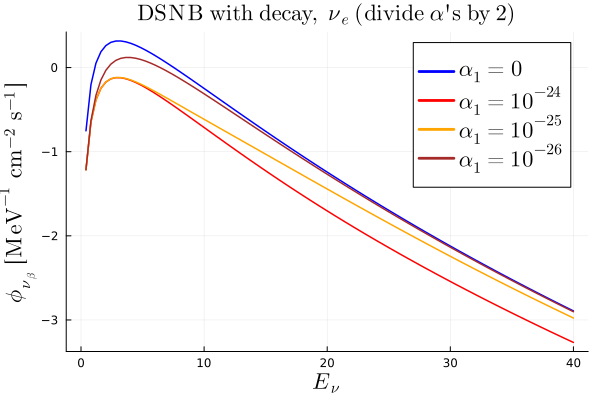

In [29]:
p1 = plot(es_dsnb, 
    [log10.(dsnb_nodecay_test_νe) log10.(dsnb_idecay_test_νe_24) log10.(dsnb_idecay_test_νe_25) log10.(dsnb_idecay_test_νe_26)],
    c=[:blue :red :orange :brown],
    lw=1.5,
    ls=[:solid :solid :solid :solid],
    label=[L"\alpha_1 = 0" L"\alpha_1 = 10^{-24}" L"\alpha_1 = 10^{-25}" L"\alpha_1 = 10^{-26}"],
    title=L"\mathrm{DSNB~with~decay,~}\nu_e~(\mathrm{divide~\alpha's~by~2})",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
)

In [158]:
# Detector stuff now

# Energy resolution
function δ(Ee, experiment, channel)
    if experiment == "HK"
        if channel == "IBD"
            return 0.1*sqrt(Ee)
        elseif channel == "ES"
            return 0.0349*Ee + 0.376*sqrt(Ee) - 0.123
        else
            return println("error")
        end
    else
        return println("error")
    end
end

ϵIBD = 0.67
NtIBD = 2.5e34
Δ = mass_neutron - mass_proton

# Response function
K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function expnew(x)
    if exp(x) == Inf
        return 1e30
    else
        return exp(x)
    end
end

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)


function diff_event_rate_IBD(Ee)
    Eν = Ee + Δ
    return ϵIBD * NtIBD * σIBD(Eν) * DSNB_idecay_flavor_fastint(Eν, "e", 0, 0, 0, "NO", true, "21")
end

event_rate_IBD_noeres(Ee_min, Ee_max) = 525600 * 60 * 20 * quadgk(Ee -> diff_event_rate_IBD(Ee), Ee_min, Ee_max)[1]

function event_rate_IBD(Ee_min, Ee_max)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * 20 * quadgk(Eetrue -> diff_event_rate_IBD(Eetrue)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue)[1]
end


event_rate_IBD (generic function with 1 method)

In [161]:
event_rate_IBD(20, 22)

29.709753135437495

In [164]:
es_plot2 = 12:2:32

dsnb_gridded = event_rate_IBD_noeres.(es_plot2, es_plot2 .+ 2);

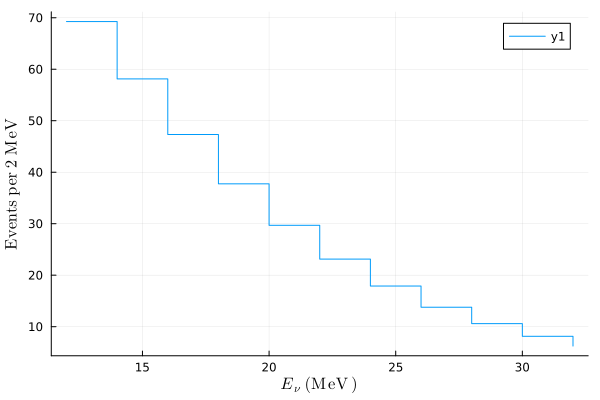

In [167]:
plot(es_plot2, dsnb_gridded, seriestype=:step, xlabel=L"E_\nu~\mathrm{(MeV)}", ylabel=L"\mathrm{Events~per~2~MeV}")